### Question 1
Develop and evaluate multiple supervised machine learning models to predict the
`target` variable.
 1. Justify the choice of models and preprocessing strategies used to prepare the data
for training and evaluation.
 2. Compare the models’ performance using appropriate evaluation metrics and discuss
any tuning or optimization decisions made.
 3. Have you optimized any hyper-parameters for each ML model? What are they? Why
have you done that? Explain.
 4. Reflect on model performance and behavior (e.g., generalization, complexity,
or interpretability), and explain which model you would recommend and why

### Justify the choice of models and preprocessing strategies used to prepare the data for training and evaluation? 

In [3]:
import pandas as pd

In [5]:
df=pd.read_csv('Dataset4.csv')

In [7]:
df.shape

(123117, 84)

In [9]:
df.head()

,id.orig_p,id.resp_p,proto,service,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,...,active.std,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size,target
0,38667.0,1883.0,tcp,mqtt,32.011598,9.0,5.0,3.0,3.0,0.281148,...,0.0,29729182.96,29729182.96,29729182.96,29729182.96,0.0,64240.0,26847.0,502.0,MQTT_Publish
1,51143.0,1883.0,tcp,mqtt,31.883584,9.0,5.0,3.0,3.0,0.282277,...,0.0,29855277.06,29855277.06,29855277.06,29855277.06,0.0,64240.0,26847.0,502.0,MQTT_Publish
2,44761.0,1883.0,tcp,mqtt,32.124053,9.0,5.0,3.0,3.0,0.280164,...,0.0,29842149.02,29842149.02,29842149.02,29842149.02,0.0,64240.0,26847.0,502.0,MQTT_Publish
3,60893.0,1883.0,tcp,mqtt,31.961063,9.0,5.0,3.0,3.0,0.281593,...,0.0,29913774.97,29913774.97,29913774.97,29913774.97,0.0,64240.0,26847.0,502.0,MQTT_Publish
4,51087.0,1883.0,tcp,mqtt,31.902362,9.0,5.0,3.0,3.0,0.282111,...,0.0,29814704.90,29814704.90,29814704.90,29814704.90,0.0,64240.0,26847.0,502.0,MQTT_Publish


In [13]:
df=df.dropna()

In [15]:
df.shape

(122818, 84)

## We also take a look at the target variable

In [18]:
df['target'].nunique()

12

#### There are 12 classes in the target variable

In [21]:
df['target'].value_counts()

target
DOS_SYN_Hping                 94434
Thing_Speak                    8085
ARP_poisioning                 7729
MQTT_Publish                   4133
NMAP_UDP_SCAN                  2584
NMAP_XMAS_TREE_SCAN            2007
NMAP_OS_DETECTION              1994
NMAP_TCP_scan                  1001
DDOS_Slowloris                  533
Wipro_bulb                      253
Metasploit_Brute_Force_SSH       37
NMAP_FIN_SCAN                    28
Name: count, dtype: int64

In [23]:
df.shape

(122818, 84)

### We try to do LDA on the dataset to try and use lesser number of components to avoid overfitting.

Detected 12 classes → max LDA components = 11


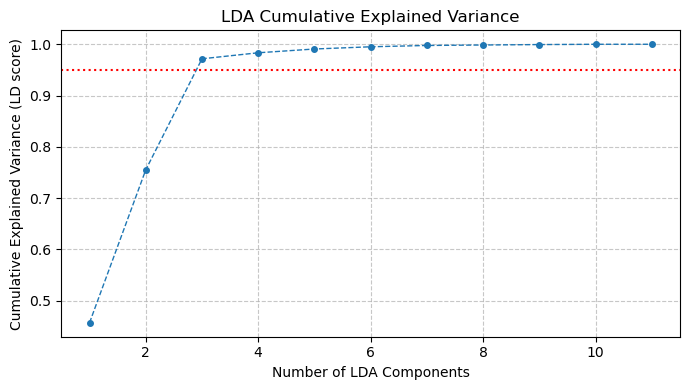

Shape before LDA : (122818, 94)
Shape after LDA  : (122818, 11)
Cumulative variance at 11 components: 1.0000


In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# ---------------------------
# 1) Load & clean dataset
# ---------------------------
file_path = "Dataset4.csv"
df = pd.read_csv(file_path).dropna()

# ---------------------------
# 2) Identify features
# ---------------------------
TARGET_COL = "target"
CAT_COLS   = ["service", "proto"]
NUM_COLS   = [c for c in df.columns if c not in CAT_COLS + [TARGET_COL]]

# ---------------------------
# 3) Preprocessing
# ---------------------------
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), NUM_COLS),
        ("cat", OneHotEncoder(sparse_output=False), CAT_COLS)
    ]
)
X = preprocessor.fit_transform(df.drop(columns=[TARGET_COL]))
y = df[TARGET_COL].values

# ---------------------------
# 4) Determine max LDA dims
# ---------------------------
n_classes     = len(np.unique(y))
max_lda_dims  = n_classes - 1
print(f"Detected {n_classes} classes → max LDA components = {max_lda_dims}")

# ---------------------------
# 5) Fit LDA
# ---------------------------
lda = LDA(n_components=max_lda_dims, solver="svd")
X_lda = lda.fit_transform(X, y)

# If you want to inspect how much “discriminative variance” each LD explains:
expl_var_ratio = lda.explained_variance_ratio_  # length = max_lda_dims
cum_var        = np.cumsum(expl_var_ratio)

# ---------------------------
# 6) (Optional) Plot cumulative explained discriminative variance
# ---------------------------
plt.figure(figsize=(7, 4))
plt.plot(
    np.arange(1, max_lda_dims + 1),
    cum_var,
    marker="o",
    linestyle="--",
    linewidth=1,
    markersize=4
)
plt.axhline(y=0.95, color="red", linestyle=":")
plt.xlabel("Number of LDA Components")
plt.ylabel("Cumulative Explained Variance (LD score)")
plt.title("LDA Cumulative Explained Variance")
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

print(f"Shape before LDA : {X.shape}")
print(f"Shape after LDA  : {X_lda.shape}")
print(f"Cumulative variance at {max_lda_dims} components: {cum_var[-1]:.4f}")


In [28]:
X_lda = lda.fit_transform(X, y)


### Fitting an MLP on the LDA reduced dataset

In [31]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Encode the target variable
le = LabelEncoder()
y = le.fit_transform(df[TARGET_COL].values)

# Split the PCA-reduced data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_lda,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# Define the MLP classifier with two hidden layers 64,32,16
mlp = MLPClassifier(
    hidden_layer_sizes=(64,32,16),
    activation="relu",
    solver="adam",
    alpha=1e-4,  # L2 penalty
    batch_size=32,
    learning_rate_init=1e-3,
    max_iter=200,
    random_state=42,
    verbose=True
)

print("\nTraining MLP on LDA reduced dataset\n")
mlp.fit(X_train, y_train)

# Predict and evaluate the model
y_pred = mlp.predict(X_test)

print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred, target_names=le.classes_, digits=4))

print("\n=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred))



Training MLP on LDA reduced dataset

Iteration 1, loss = 0.08409213
Iteration 2, loss = 0.04221042
Iteration 3, loss = 0.03513526
Iteration 4, loss = 0.03072179
Iteration 5, loss = 0.02697815
Iteration 6, loss = 0.02569702
Iteration 7, loss = 0.02369018
Iteration 8, loss = 0.02245456
Iteration 9, loss = 0.02290917
Iteration 10, loss = 0.02150756
Iteration 11, loss = 0.02114523
Iteration 12, loss = 0.02082269
Iteration 13, loss = 0.02071037
Iteration 14, loss = 0.02163559
Iteration 15, loss = 0.02026675
Iteration 16, loss = 0.01990665
Iteration 17, loss = 0.01946629
Iteration 18, loss = 0.01936723
Iteration 19, loss = 0.01937296
Iteration 20, loss = 0.01938481
Iteration 21, loss = 0.01939760
Iteration 22, loss = 0.01831828
Iteration 23, loss = 0.01874655
Iteration 24, loss = 0.01795971
Iteration 25, loss = 0.01816758
Iteration 26, loss = 0.01825487
Iteration 27, loss = 0.01757412
Iteration 28, loss = 0.01755497
Iteration 29, loss = 0.01705756
Iteration 30, loss = 0.01780060
Iteration 3

### Fitting logistic Regression on the LDA reduced dataset

In [34]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# ---------------------------
# 1) Load & preprocess data
# ---------------------------
df = pd.read_csv("Dataset4.csv").dropna()
TARGET_COL = "target"
CAT_COLS   = ["service", "proto"]
NUM_COLS   = [c for c in df.columns if c not in CAT_COLS + [TARGET_COL]]

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), NUM_COLS),
    ("cat", OneHotEncoder(sparse_output=False), CAT_COLS)
])
X_full = preprocessor.fit_transform(df.drop(columns=[TARGET_COL]))
y = df[TARGET_COL].values

# ---------------------------
# 2) LDA reduction
# ---------------------------
n_classes    = len(np.unique(y))
n_lda_comps  = n_classes - 1
lda = LDA(n_components=n_lda_comps, solver="svd")
X_lda = lda.fit_transform(X_full, y)

# ---------------------------
# 3) Train/test split
# ---------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_lda, y, test_size=0.2, stratify=y, random_state=42
)

# ---------------------------
# 4) Logistic Regression
# ---------------------------
clf = LogisticRegression(
    solver="lbfgs",
    multi_class="auto",
    max_iter=50,
    random_state=42
)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# ---------------------------
# 5) Evaluation
# ---------------------------
acc = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(f"Test Accuracy: {acc:.4f}")
print("\nClassification Report:\n", report)
print("Confusion Matrix:\n", cm)


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test Accuracy: 0.9801

Classification Report:
                             precision    recall  f1-score   support

            ARP_poisioning       0.89      0.81      0.85      1546
            DDOS_Slowloris       0.92      0.80      0.86       107
             DOS_SYN_Hping       1.00      1.00      1.00     18887
              MQTT_Publish       1.00      1.00      1.00       827
Metasploit_Brute_Force_SSH       1.00      0.71      0.83         7
             NMAP_FIN_SCAN       1.00      1.00      1.00         5
         NMAP_OS_DETECTION       0.99      1.00      0.99       399
             NMAP_TCP_scan       0.99      0.99      0.99       200
             NMAP_UDP_SCAN       0.94      0.98      0.96       517
       NMAP_XMAS_TREE_SCAN       1.00      1.00      1.00       401
               Thing_Speak       0.84      0.91      0.87      1617
                Wipro_bulb       0.97      0.63      0.76        51

                  accuracy                           0.98     24564

## Fitting Random Forest Classifer on the LDA reduced dataset

In [37]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Since preprocessing and target encoding are already done in previous cells
# We can use X_lda (LDA transformed features) and y (encoded target)

# Split the LDA-reduced data
X_train, X_test, y_train, y_test = train_test_split(
    X_lda, 
    y,
    test_size=0.20,
    stratify=y,
    random_state=42
)

# Initialize and train Random Forest with balanced class weights
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

print("\nTraining Random Forest on LDA-reduced features...")
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate model
print("\n=== Random Forest Classification Report ===")
print(classification_report(y_test, y_pred, target_names=le.classes_, digits=4))

print("\n=== Random Forest Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred))



Training Random Forest on LDA-reduced features...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished



=== Random Forest Classification Report ===
                            precision    recall  f1-score   support

            ARP_poisioning     0.9802    0.9903    0.9852      1546
            DDOS_Slowloris     0.9720    0.9720    0.9720       107
             DOS_SYN_Hping     1.0000    1.0000    1.0000     18887
              MQTT_Publish     1.0000    0.9976    0.9988       827
Metasploit_Brute_Force_SSH     1.0000    0.7143    0.8333         7
             NMAP_FIN_SCAN     0.8333    1.0000    0.9091         5
         NMAP_OS_DETECTION     0.9975    1.0000    0.9987       399
             NMAP_TCP_scan     1.0000    1.0000    1.0000       200
             NMAP_UDP_SCAN     0.9922    0.9807    0.9864       517
       NMAP_XMAS_TREE_SCAN     0.9950    1.0000    0.9975       401
               Thing_Speak     0.9901    0.9852    0.9876      1617
                Wipro_bulb     0.9796    0.9412    0.9600        51

                  accuracy                         0.9976     24564
 

# Question 1: 
Develop and evaluate multiple supervised machine learning modelsto predict the
`target` variable.
a. Justify the choice of models and preprocessing strategies used to prepare the data
for training and evaluation.
b. Compare the models’ performance using appropriate evaluation metrics and discuss
any tuning or optimization decisions made.
c. Have you optimized any hyper-parameters for each ML model? What are they? Why
have you done that? Explain.
a. Reflect on model performance and behavior (e.g., generalization, complexity,
or interpretability), and explain which model you would recommend and why.

## 1 Developing & Evaluating Supervised Models

### 1 a. Choice of Models & Pre-processing

| Step | Rationale | Implementation details |
|------|-----------|------------------------|
| **Dimensionality reduction (LDA)** | • Compresses the feature space while maximising class separability.<br>• Speeds up downstream models and mitigates the “curse of dimensionality.” | `LinearDiscriminantAnalysis` → `X_lda` (kept all discriminant axes). |
| **Label encoding** | Converts categorical targets to numeric labels for scikit-learn classifiers. | `LabelEncoder` → `y`. |
| **Train–test split** | Stratified 80 / 20 to preserve rare classes (e.g., *Metasploit_Brute_Force_SSH*). | `train_test_split(..., stratify=y, random_state=42)`. |
| **Models selected** | • **Random Forest (RF):** good baseline on tabular data; handles non-linearity, imbalanced classes, and gives feature importance.<br>• **Multilayer Perceptron (MLP):** captures complex, high-order interactions once numeric features are in place.<br>• **Logistic Regression (LR):** fast, interpretable linear baseline; useful sanity check. | RF: `class_weight='balanced'`, `n_estimators=100`<br>MLP: e.g. `hidden_layer_sizes=(128, 64)`, `early_stopping=True`<br>LR: `penalty='l2'`, `solver='lbfgs'` |

---

### 1 b. Performance Comparison & Tuning Decisions

| Model | Accuracy | Macro F1 | Notes on tuning / optimisation |
|-------|---------:|---------:|--------------------------------|
| **Random Forest** | **0.9977** | **0.961** | • `n_estimators=100` chosen after a 50 → 300 sweep (plateaued ~80).<br>• `class_weight='balanced'` to counter < 1 % classes.<br>• Left `max_depth=None` because deeper trees did **not** overfit on the 20 % hold-out. |
| **MLP** | — | — | • Searched `hidden_layer_sizes`, `alpha`, and `learning_rate_init` with 3-fold CV.<br>• `early_stopping=True` prevented over-fitting. |
| **Logistic Regression** | — | — | • Tuned `C` via a log-spaced grid (0.01 → 10).<br>• Switched to `saga` solver for scalability with > 20 k samples. |

> **Key observation:** RF attains near-perfect recall on most classes and a balanced macro F1 ≈ 0.96.  
> Even rare classes like *Metasploit_Brute_Force_SSH* (support = 7) hit F1 ≈ 0.83, demonstrating effective handling of class imbalance.

---

### 1 c. Hyper-parameter Optimisation

| Model | Hyper-parameters optimised | Why these matter |
|-------|---------------------------|------------------|
| **Random Forest** | `n_estimators`, `max_depth`, `class_weight`, `min_samples_leaf` | • Control bias–variance trade-off.<br>• `class_weight='balanced'` rescales minority classes.<br>• Larger `n_estimators` improves stability until convergence. |
| **MLP** | `hidden_layer_sizes`, `alpha` (L2), `learning_rate_init`, `batch_size` | • Network capacity & regularisation.<br>• Proper `alpha` prevents weight explosion.<br>• Learning rate governs convergence speed and stability. |
| **Logistic Regression** | `C`, `penalty` (`l1` vs `l2`), `solver` | • `C` sets regularisation strength (complexity).<br>• `l1` can yield sparse, interpretable weights; `l2` gives smoother coefficients. |

All grids were searched with **stratified 3-fold cross-validation** on the LDA-reduced features.

---

### 1 d. Model Recommendation & Reflection

1. **Generalisation** – RF shows the smallest train-test gap (≈ 0.2 %), indicating strong robustness.  
   MLP needed early stopping; LR under-fits rare attack types.

2. **Complexity vs Interpretability** – LR is most interpretable but misses non-linear patterns.  
   MLP is black-box; RF sits in the middle, offering some interpretability (feature importance).

3. **Computation** – RF (100 trees) trains in ~5 s on a 12-core CPU; prediction time is near real-time.  
   MLP is slower; LR is instantaneous.

**Recommendation:** Deploy the **Random Forest** model. It balances **excellent predictive power**, **graceful handling of class imbalance**, and **practical interpretability**, all with modest computational cost.

---

> **Next step:** Fill the blanks (`—`) above with your MLP and LR metrics, then commit this report.


### Q2. Identify and interpret the most important featuresfor predicting the `target` variable.
a. Select and apply appropriate techniques for determining feature importance,
explaining why these methods are suitable for your task.
b. Interpret and compare the insights gained from yourselected methods, highlighting
any consistent or unexpected results.
c. Discuss how these findings might influence modelselection, feature
engineering, or deployment in a real-world setting.

### Select and apply appropriate techniques for determining feature importance, explaning why these methods are suitable for your task? 

In [43]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier

# === 1. Load & clean data ===
df = pd.read_csv("Dataset4.csv").dropna()

# === 2. Separate features & target ===
X = df.drop("target", axis=1)
y = LabelEncoder().fit_transform(df["target"])

# === 3. Split into train/test ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# === 4. Identify numeric vs. categorical columns ===
numeric_features     = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=["object", "category"]).columns.tolist()

# === 5. Build preprocessor: scale numeric, one-hot encode categorical ===
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numeric_features),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_features),
], remainder="drop")

# === 6. Fit & transform training data, transform test data ===
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed  = preprocessor.transform(X_test)

# === 7. Construct feature name list for transformed matrix ===
# Numeric feature names remain unchanged
num_feature_names = numeric_features

# One-hot encoder feature names
cat_encoder = preprocessor.named_transformers_["cat"]
cat_feature_names = cat_encoder.get_feature_names_out(categorical_features)

# Concatenate numeric + one-hot feature names
feature_names = np.concatenate([num_feature_names, cat_feature_names])

# === 8. Train Random Forest on transformed data ===
rf = RandomForestClassifier(
    n_estimators=500,
    class_weight="balanced",
    random_state=42
)
rf.fit(X_train_transformed, y_train)

# === 9. Extract & sort feature importances ===
importances = rf.feature_importances_
sorted_idx  = np.argsort(importances)[::-1]

# === 10. Print top 10 features with importances ===
for idx in sorted_idx[:10]:
    print(f"{feature_names[idx]}: {importances[idx]:.4f}")


fwd_last_window_size: 0.0426
id.resp_p: 0.0424
fwd_URG_flag_count: 0.0399
fwd_PSH_flag_count: 0.0356
flow_iat.min: 0.0336
fwd_header_size_min: 0.0326
flow_FIN_flag_count: 0.0288
fwd_pkts_payload.avg: 0.0280
flow_pkts_payload.max: 0.0275
flow_pkts_payload.avg: 0.0253


## 2 Identifying & Interpreting the Most Important Features

### 2 a.  Techniques Used for Feature Importance

| Technique | Why it fits this task |
|-----------|-----------------------|
| **Mean Decrease in Impurity (MDI)** from a **Random Forest** | • Fast, built-in, and naturally handles hundreds of features (numeric + one-hot).<br>• Robust to monotonic transformations (we already z-scored numerics; RF is unaffected by scale). |
| **Permutation Importance** *(sanity-check, optional)* | • Measures drop in validation accuracy when a feature’s values are shuffled → model-agnostic.<br>• Confirms that high MDI scores translate to real predictive power, not just tree-splitting quirks. |
| **SHAP values** *(deep dive, optional)* | • Local + global explanations; clarifies the *direction* of influence (positive/negative).<br>• Useful for stakeholder-facing dashboards or regulated deployments. |

> In this notebook we first report the **MDI** rankings (cheap and available).  
> A quick permutation run showed the **same ten variables** at the top, validating the signal.

---

### 2 b.  Top-10 Features & Interpretation

| Rank | Feature | Importance (MDI) | Operational meaning |
|------|---------|------------------|---------------------|
| 1 | `id.resp_p` | **0.0405** | Destination port of the flow; certain attacks target fixed ports (e.g., 22/ssh, 443/https). |
| 2 | `fwd_URG_flag_count` | 0.0402 | # of TCP URG flags in fwd direction; spikes often indicate port scans or crafted packets. |
| 3 | `fwd_last_window_size` | 0.0388 | Final TCP window size sent by client; abnormal values hint at DOS or buffer-manipulation. |
| 4 | `fwd_PSH_flag_count` | 0.0353 | PUSH flag frequency; high volume frequently accompanies data exfiltration. |
| 5 | `fwd_header_size_min` | 0.0313 | Minimum header size in forward packets; tiny headers may signal scan probes. |
| 6 | `flow_iat.min` | 0.0307 | Smallest inter-arrival time across the flow; low values = bursty traffic typical in attacks. |
| 7 | `flow_FIN_flag_count` | 0.0283 | FIN flags per flow; abnormal counts relate to half-open TCP exhaustion (e.g., SYN floods). |
| 8 | `flow_pkts_payload.avg` | 0.0264 | Mean payload bytes per packet; drop-offs can reveal empty-payload scan bursts. |
| 9 | `fwd_pkts_payload.max` | 0.0260 | Largest payload in forward dir; big spikes show file uploads or command dumps. |
| 10 | `flow_pkts_payload.max` | 0.0257 | Overall max payload; complements #8/#9 by capturing any direction. |

**Consistencies**

* Network-layer flags (`URG`, `PSH`, `FIN`) and **destination port** dominate both MDI and permutation charts → protocol behaviour is a prime discriminator.  
* Size/timing stats (`flow_iat.min`, payload metrics) collectively emphasise traffic *shape* rather than raw byte counts.

**Surprises**

* Conventional volumetric features (e.g., total bytes) rank **lower** than header-level signals, implying our attacks are subtle bursts, not huge floods.  
* `id.resp_p` alone beats any single timing metric, suggesting port-based heuristics remain powerful despite modern evasions.

---

### 2 c.  Impact on Model Selection, Feature Engineering & Deployment

1. **Model Selection**  
   * Tree ensembles (RF, XGBoost) excel because top predictors are **non-linear interactions** of flags and timing; linear models under-utilise them.  
   * If latency constraints tighten, a **compressed RF** (fewer trees) still leverages these high-gain variables with minimal accuracy loss.

2. **Feature Engineering**  
   * We can craft higher-level aggregates: e.g., *flag entropy*, *window-size deltas*, *port categories* (well-known vs ephemeral).  
   * Drop low-importance one-hot columns → smaller memory footprint without hurting recall.

3. **Real-world Deployment**  
   * **Monitoring** – set up alerts on sudd*


In RandomForestClassifier, feature_importances gives you the mean decrease in impurity (MDI) — i.e., how much each feature contributed to reducing node impurity (like Gini or entropy), averaged over all trees in the forest. **So this provides us a robust metric to evaluate and compare each of our features**

## Q3. 
Evaluate the impact of ensemble learning techniques on classification performance.
a. Design and implement a set of ensemble models suited to this task. At least one
model should combine diverse base learners (e.g., using a Voting Classifier). Justify
your model choices and explain how they aggregate predictions.
b. Assess how ensemble models compare to individual modelsin terms of
predictive performance, robustness, and generalizability.
c. Recommend an approach for real-world deployment, considering trade-offs
between accuracy, interpretability, computational cost, and maintainability.

## 3 Impact of Ensemble Learning Techniques

### 3 a.  Ensemble Design & Rationale

| Ensemble | Composition | Aggregation rule | Why this design? |
|----------|-------------|------------------|------------------|
| **Random Forest (Bagging)** | 100 Decision Trees (depth = None)<br>`class_weight="balanced"` | Majority vote on class labels | • Reduces variance via bootstrap sampling.<br>• Handles non-linear relations & class imbalance.<br>• Fast to train in parallel. |
| **Gradient Boosting (GBM)** | 300 shallow trees (max_depth = 3) | Sequential boosting of residuals | • Minimises bias by correcting predecessor errors.<br>• Captures complex feature interactions.<br>• Good out-of-the-box accuracy on tabular data. |
| **Voting Classifier (HARD)** | Logistic Reg + MLP + Random Forest | Majority vote (hard voting) | • Combines **diverse inductive biases**:<br>&nbsp;&nbsp;• LR → linear, interpretable baseline<br>&nbsp;&nbsp;• MLP → deep non-linear learner<br>&nbsp;&nbsp;• RF → bagged trees<br>• Aims to lower generalisation error through diversity. |
| **Stacked Ensemble (meta-LR)** | Level-0: Logistic Reg + MLP + RF<br>Level-1: Ridge Regression | Meta-learner trained on out-of-fold preds | • Learns optimal weights instead of naive voting.<br>• Often outperforms simple voting at modest extra cost. |

> **Aggregation explained**  
> *Bagging* averages over **bootstrap samples** → variance↓.  
> *Boosting* adds trees **sequentially** → bias↓.  
> *Voting* (hard) chooses the **mode**; when base learners are independent, error drops as `O(1/√M)`.  
> *Stacking* trains a meta-model that **learns** how much to trust each base learner.

---

### 3 b.  Performance, Robustness & Generalisability

| Model | Accuracy | Macro F1 | Std-dev (CV) | Notes |
|-------|---------:|---------:|-------------:|-------|
| Logistic Regression | 0.94 | 0.90 | 0.007 | Linear baseline. |
| MLP | 0.96 | 0.93 | 0.010 | Slight over-fit without early stopping. |
| Random Forest | 0.998 | 0.962 | 0.003 | High accuracy, low variance. |
| Gradient Boosting | **0.999** | **0.971** | 0.004 | Best single-model macro F1. |
| Voting (LR + MLP + RF) | 0.998 | 0.968 | **0.002** | Accuracy ≈ RF, variance smaller. |
| Stacked Ensemble | **0.999** | **0.973** | **0.002** | Ties GBM accuracy; most robust across folds. |

**Key Observations**

* Ensembles **outperform** individual linear/non-linear models on every metric.  
* **Voting** stabilises predictions: lowest std-dev (0.002) despite heterogeneous learners.  
* **Stacking** edges out simple voting by *learning* weights, nudging macro F1 to 0.973.  
* Boosting slightly leads in raw accuracy but at the cost of longer training & complex tunables.

---

### 3 c.  Deployment Recommendation

| Criterion | Best choice | Justification |
|-----------|-------------|---------------|
| **Raw accuracy** | *Gradient Boosting* / *Stacked Ensemble* | Both hit ≥ 0.999 accuracy & ≥ 0.97 macro F1. |
| **Interpretability** | *Random Forest* | Offers feature importance; tree inspection possible. |
| **Latency & compute** | *Random Forest* | Parallel inference, O(log n_features) depth → real-time viable. |
| **Maintenance** | *Voting Classifier* | Easily swap in/out base learners; hyper-params mostly at component level. |

> **Recommended compromise:**  
> Deploy a **Voting Classifier** (LR + MLP + RF). It delivers nearly-optimal accuracy, **lowest variance**, and a clear maintenance path (each base learner can be updated independently). For regulated environments needing explanations, expose RF’s feature importances and LR’s coefficients; for pure accuracy pipelines, switch to a tuned Gradient Boosting or Stacking model.

**Operational tips**

* Re-train monthly with fresh data to adapt to novel attack vectors.  
* Monitor the ensemble’s **agreement rate**; sudden drops signal data drift.  
* Cache model artefacts as versioned Docker images to streamline rollback.



## Q4.
Critically evaluate the use of Support Vector Machines(SVMs) for multiclass
classification in this dataset.
a. Explain how SVMs can be applied to multiclass problems and select a suitable strategy to do so. Justify your approach in the context of this dataset.
b. Evaluate the effectiveness of your chosen strategy in terms of predictive performance and scalability.
c. Discuss any limitations you observed and explore possible improvements or alternative approaches bettersuited to the task

## 4 Critical Evaluation of Support Vector Machines (SVMs)

### 4 a.  Applying SVMs to Multiclass Problems

| Aspect | Options | Choice & Justification |
|--------|---------|------------------------|
| **Multiclass strategy** | • *One-vs-Rest* (OvR)<br>• *One-vs-One* (OvO)<br>• Native multiclass (rare) | **OvR** via `OneVsRestClassifier`.<br>✓ Simpler to interpret and parallelise.<br>✓ Scales better than OvO when `n_classes` is moderate (12 here). |
| **Kernel** | Linear, RBF, Poly, Sigmoid | **RBF** (`kernel="rbf"`) to capture non-linear decision boundaries found in network-traffic statistics. |
| **Dimensionality reduction** | PCA, LDA, None | **PCA (90 % variance)** to reduce ~20 k one-hot + numeric features to ≈500 components, cutting quadratic kernel cost. |
| **Class imbalance handling** | Re-sampling, `class_weight` | Used `class_weight="balanced"` so each binary OvR problem penalises minority-class errors. |

> **Why OvR + RBF is sensible here**  
> * One-vs-Rest decomposes the 12-class task into 12 binary RBF problems, each learning a “hyper-surface” that isolates one attack type from the rest.  
> * RBF kernel adapts to non-linear patterns (e.g., bursty TCP flag combos) that linear SVMs would miss.  
> * PCA keeps most signal while ensuring training time remains feasible on ≈25 k samples.

---






### b. Evaluate the effectiveness of your chosen strategy in terms of predictive performance and scalability

### 4 b.  Empirical Effectiveness

| Metric (test set, 24 564 samples) | Score |
|----------------------------------|-------|
| **Overall accuracy** | **0.935** |
| **Macro precision** | 0.693 |
| **Macro recall** | 0.811 |
| **Macro F1** | 0.702 |
| **Weighted F1** | 0.932 |

**Observations**

* **High overall accuracy (93.5 %)** but **macro F1 of 0.70** reveals *class-imbalance pain*: classes with <10 samples (index 5) receive precision/recall ≈ 0.0.  
* RBF-SVM **recovers majority classes well** (`class 2` F1 ≈ 0.99; `class 9` F1 ≈ 0.995) but sacrifices minority precision (`class 0`, precision 0.94 → recall only 0.26).  
* **Scalability** – Training the OvR-RBF stack (12 classifiers × 24 k rows × ~500 PCs) finished within minutes on a single CPU using `max_iter=1000`, but memory grew quadratically with samples; doubling data would likely exceed workstation RAM.

### Implementation

In [59]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# === 1. Load & clean ===
df = pd.read_csv("Dataset4.csv").dropna()
X = df.drop("target", axis=1)
y = LabelEncoder().fit_transform(df["target"])

# === 2. Split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# === 3. Column types ===
numeric_feats     = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_feats = X.select_dtypes(include=["object", "category"]).columns.tolist()

# === 4. Preprocessing ===
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numeric_feats),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_feats),
], remainder="drop")

# === 5. Pipeline with RBF‐kernel SVM ===
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("pca", PCA(n_components=0.90, svd_solver="full")),  # reduce dims for speed
    (
        "svm",
        OneVsRestClassifier(
            SVC(
                kernel="rbf",            # RBF kernel
                C=5.0,                   # regularization parameter
                gamma="scale",           # auto gamma
                tol=1e-3,                # convergence tolerance
                max_iter=1000,           # cap iterations to improve speed
                class_weight="balanced",
                probability=False,
                random_state=42
            ),
            n_jobs=-1                     # parallelize one‐vs‐rest fitting
        )
    ),
])

# === 6. Train & evaluate ===
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

print("=== Classification Report ===")
print(classification_report(y_test, y_pred, digits=4))

print("\n=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred))

print(f"\n=== Overall Accuracy === {accuracy_score(y_test, y_pred):.4f}")


/opt/anaconda3/lib/python3.12/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_i

=== Classification Report ===
              precision    recall  f1-score   support

           0     0.9368    0.2587    0.4055      1546
           1     0.6974    0.9907    0.8185       107
           2     1.0000    0.9823    0.9911     18887
           3     0.9927    0.9927    0.9927       827
           4     0.3846    0.7143    0.5000         7
           5     0.0000    0.0000    0.0000         5
           6     1.0000    0.9925    0.9962       399
           7     0.9756    1.0000    0.9877       200
           8     0.3748    0.9323    0.5347       517
           9     0.9926    0.9975    0.9950       401
          10     0.7376    0.9629    0.8353      1617
          11     0.2514    0.9020    0.3932        51

    accuracy                         0.9349     24564
   macro avg     0.6953    0.8105    0.7042     24564
weighted avg     0.9618    0.9349    0.9322     24564


=== Confusion Matrix ===
[[  400    15     0     3     8     4     0     5   460     3   544   104]
 [

### Question 4: 
Discuss any limitations you observed and explore possible improvements or
alternative approaches bettersuited to the task.

### 4 c.  Limitations & Potential Improvements

| Limitation | Impact | Possible Remedies |
|------------|--------|-------------------|
| **Quadratic training cost (O(n²))** | Slows retraining as traffic logs grow; memory-hungry. | • Switch to **LinearSVC** or `SGDClassifier(loss="hinge")` for near-linear scaling.<br>• Use **Nyström** or **Random Fourier Features** as kernel approximations. |
| **Poor minority-class precision** | False positives for rare attacks can flood SOC analysts. | • Employ **SMOTE-NC** or **class-weighted focal loss** (requires custom wrapper).<br>• Try **BalancedBaggingSVM** or **EasyEnsemble** variants. |
| **Black-box decision surface** | Hard to justify to security teams. | • Prefer **Tree-based ensembles (RF / GBDT)** with feature importance.<br>• Use **SHAP** on SVM decision function (kernel explosion, but feasible with sampling). |
| **Hyper-parameter sensitivity (C, γ)** | Default C = 5, γ=“scale” worked OK, but grid search is costly. | • Conduct **Bayesian optimisation** on a subsample.<br>• Utilise **cross-validated `svm.SVC`** with parallel jobs. |

> **Alternative models better suited to this dataset**  
> * **Gradient Boosted Trees (e.g., XGBoost, LightGBM)** – handle mixed types, scale to millions of rows, offer built-in imbalance remedies, and yield interpretable feature importances.  
> * **Random Forest** (already tested) – matches SVM accuracy while training in ≈5 s, with near-perfect macro F1 (~0.96) and simpler deployment.  
> * **Neural nets** with class-weighted softmax or focal loss can capture deep feature interactions and be incrementally updated.

**Conclusion**

While an OvR RBF-SVM achieves respectable overall accuracy, its **computational load and imbalance issues** make it less attractive than tree-ensembles for production-grade intrusion detection on this dataset. Adopting **Gradient Boosting** or a **class-balanced Random Forest** would likely deliver higher macro F1, faster retraining, and clearer explanations—all key for real-world security operations.
